In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV 

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,\
    recall_score, f1_score, fbeta_score, precision_recall_curve, roc_curve, roc_auc_score, auc, make_scorer  #For evaluating classifier model

In [2]:
# Read data and select columns from dataframe

df = pd.read_csv('../../data/census_epa_theil_cleaned.csv')

race_columns = ['pct_pop_white_only',
                'pct_pop_black',
                'pct_pop_asian',
                'pct_pop_hispanic_latino_any']

econ_columns = ['prim_ind_share',
                'sec_ind_share', 
                'pop_density',
                'poverty_pct',
                'theil_income_median',
                'health_ins_pct']

env_columns = ['PM25',
               'OZONE',
               'DSLPM',
               'PTRAF',
               'PRE1960PCT',
               'PNPL',
               'PRMP',
               'PTSDF',
               'UST',
               'PWDIS']

# select variables 
df = df[race_columns + econ_columns + env_columns]

In [3]:
# Classify PM25 as 1 (high) or 0 (low) and perform urban cut

# define PM25_class
# threshold: PM25 > 9 (supported by EPA)
df['PM25_class'] = np.where(df['PM25'] > 9, 1 ,0)

# perform urban cut: population density > 500/sqkm
df_urban = df[df['pop_density'] > 500]


In [4]:
# defining dependant and independant variable sets
y = df_urban['PM25_class']
X = df_urban.drop(['PM25', 'PM25_class'], axis=1)

In [5]:
# Stratified train-validation-test split: 68%/12%/20% and seed=201

# 1st split: 80%/20%
X_train_and_val , X_test, y_train_and_val, y_test = train_test_split(X, y,
                                            shuffle=True,
                                            test_size=0.2,
                                            random_state = 201,
                                            stratify=y)

print("The train+val/test split percent is: " + str(len(y_train_and_val)/len(y)*100) + " / " 
                                              + str(len(y_test)/len(y)*100) + "\t")

# 1st split: 85%/15%
X_train , X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val,
                                            shuffle=True,
                                            test_size=0.15,
                                            random_state = 201,
                                            stratify=y_train_and_val)

# Printing info on split % and proportion of high/low PM25_class
print("The train/val/test split percent is: " + str(len(y_train)/len(y)*100) + " / " 
                                              + str(len(y_val)/len(y)*100) + " / " 
                                              + str(len(y_test)/len(y)*100) + "\t")

print("\nClassification: \t\t\t 1 \t\t\t 0 ")
pct_1 = y.sum()/len(y)
print("Original proportion: \t\t" + str(pct_1) + "\t" + str(1-pct_1))
pct_1 = y_train.sum()/len(y_train)
print("Training proportion: \t\t" + str(pct_1) + "\t" + str(1-pct_1))
pct_1 = y_val.sum()/len(y_val)
print("Validation proportion: \t\t" + str(pct_1) + "\t" + str(1-pct_1))
pct_1 = y_test.sum()/len(y_test)
print("Test proportion: \t\t" + str(pct_1) + "\t" + str(1-pct_1))

The train+val/test split percent is: 80.0 / 20.0	
The train/val/test split percent is: 67.99835593916976 / 12.00164406083025 / 20.0	

Classification: 			 1 			 0 
Original proportion: 		0.3383888203863543	0.6616111796136457
Training proportion: 		0.33840062862669246	0.6615993713733075
Validation proportion: 		0.33835616438356164	0.6616438356164384
Test proportion: 		0.33836826962597616	0.6616317303740238


In [6]:
# Perform scaling on all indep variables
# using MinMaxScaler - since our variables aren't normally distributed

# fit MinMaxScaler to training data
scaler = MinMaxScaler()
scaler.fit(X_train)

# apply transformation to training, validation, and test sets
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [9]:
# gridsearchCV: test n_estimators with all other parameters set to default

# Optimixing for f2 metric (similar to f1, but greater preference for recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# fix random state of classifier
rf_classifier = RandomForestClassifier(random_state = 101)

# hyperparams to search
param_grid = {'n_estimators' : [200,500,1000]}

# Using the same kfold split across all model types
mycv = kfold = StratifiedKFold(5, shuffle=True, random_state=201)

#perform grid search and cv
grid_search = GridSearchCV(rf_classifier, param_grid, scoring = f2_scorer, cv = mycv, verbose=3)
grid_search.fit(X_train,y_train)

best_forest_N = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................n_estimators=200;, score=0.778 total time=  15.7s
[CV 2/5] END ..................n_estimators=200;, score=0.797 total time=  16.0s
[CV 3/5] END ..................n_estimators=200;, score=0.777 total time=  15.8s
[CV 4/5] END ..................n_estimators=200;, score=0.787 total time=  15.6s
[CV 5/5] END ..................n_estimators=200;, score=0.778 total time=  15.7s
[CV 1/5] END ..................n_estimators=500;, score=0.787 total time=  39.2s
[CV 2/5] END ..................n_estimators=500;, score=0.796 total time=  39.2s
[CV 3/5] END ..................n_estimators=500;, score=0.777 total time=  39.3s
[CV 4/5] END ..................n_estimators=500;, score=0.791 total time=  39.2s
[CV 5/5] END ..................n_estimators=500;, score=0.780 total time=  39.4s
[CV 1/5] END .................n_estimators=1000;, score=0.784 total time= 1.3min
[CV 2/5] END .................n_estimators=1000;,

In [8]:
# gridsearchCV: tune hyperparameters and cross validation

# NOTE: seems using max_features = n_features performs better than default with fewer estimators

# Optimixing for f2 metric (similar to f1, but greater preference for recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# fix random state of classifier
rf_classifier = RandomForestClassifier(random_state = 101)

# hyperparams to search
param_grid = {'n_estimators' : [100,200,500],
              'max_depth' : [10,20,None], # default = None
              'max_samples' : [0.75,1.0], # default = 1.0
              'max_features' : [10,19] # default = 'sqrt'
             }
# Using the same kfold split across all model types
mycv = kfold = StratifiedKFold(5, shuffle=True, random_state=201)

#perform grid search and cv
grid_search = GridSearchCV(rf_classifier, param_grid, scoring = f2_scorer, cv = mycv, verbose=3)
grid_search.fit(X_train,y_train)

best_forest = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=100;, score=0.733 total time=  10.9s
[CV 2/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=100;, score=0.746 total time=  10.9s
[CV 3/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=100;, score=0.733 total time=  10.9s
[CV 4/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=100;, score=0.732 total time=  10.9s
[CV 5/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=100;, score=0.730 total time=  10.9s
[CV 1/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=200;, score=0.731 total time=  21.9s
[CV 2/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=200;, score=0.749 total time=  21.9s
[CV 3/5] END max_depth=10, max_features=10, max_samples=0.75, n_estimators=200;, score=0.734 total time=  21.9s
[CV 4/5] END max_depth=10, max_features=10

In [50]:
# Best hyperparameters from gridsearch
print('Best Hyperparameters:')
for keys,values in best_forest.get_params(deep=True).items():
    print('{}: {}'.format(keys,values))
print()

Best Hyperparameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: 19
max_leaf_nodes: None
max_samples: 1.0
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 200
n_jobs: None
oob_score: False
random_state: 101
verbose: 0
warm_start: False



METRICS: 
precision: 0.8942093541202673
recall: 0.812753036437247
f1: 0.8515376458112407
f2: 0.8278350515463916
AUC-PR: 0.9389214164927229


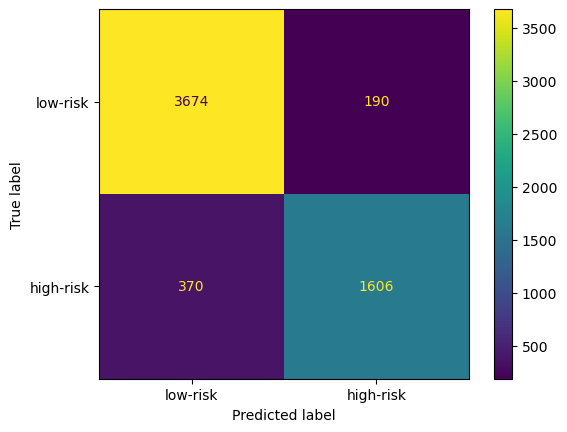

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


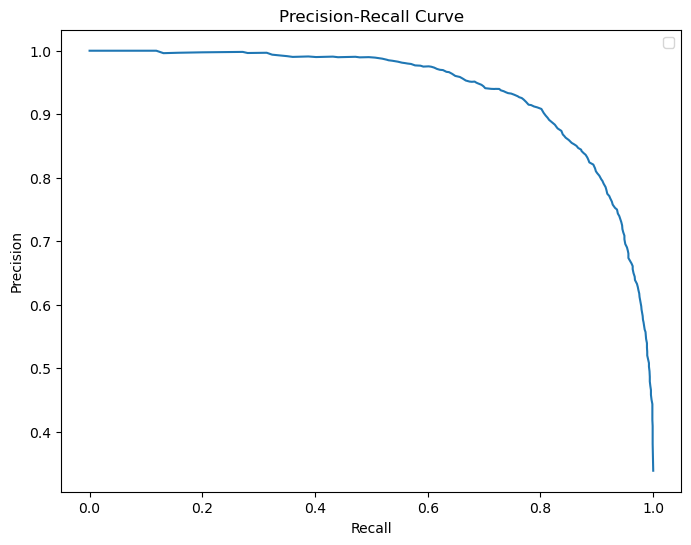

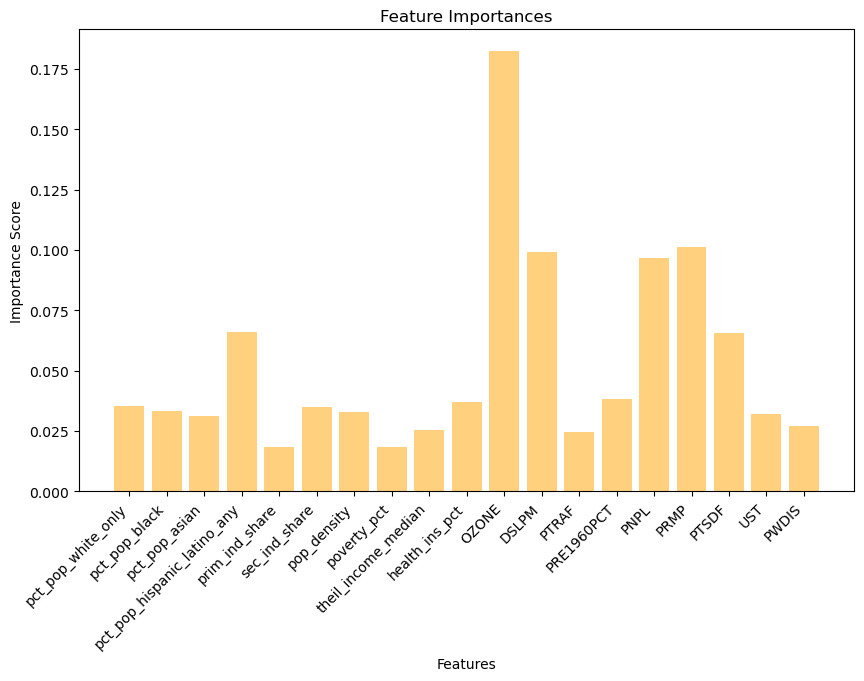

In [52]:
# Testing best random forest on validation set
rf = best_forest

# make predictions on validation set
y_pred = rf.predict(X_val)
y_prob = rf.predict_proba(X_val)[:,1]
precision, recall, _ = precision_recall_curve(y_val, y_prob)

# print metrics
print("METRICS: ")
print("precision:", str(precision_score(y_val, y_pred)) )
print("recall:", str(recall_score(y_val, y_pred)) )
print("f1:",  str(fbeta_score(y_val, y_pred, beta=1)) )
print("f2:", str(fbeta_score(y_val, y_pred, beta=2)) )
print("AUC-PR:", str(auc(recall, precision)) )

# making the confusion matrix on the validation data
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# determine feature importance
df_features = df_urban.copy()
df_features = df_features.drop(['PM25', 'PM25_class'], axis=1)
feature_list = df_features.columns.tolist()

plt.figure(figsize=(10, 6))
feature_importance = best_forest.feature_importances_
plt.bar(feature_list, feature_importance, color='orange', alpha = 0.5)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.show()